# Test Thermal Models

The instantaneous thermal models (STM, FRM, and NEATM) are tested here against [Harris (1998)](https://www.sciencedirect.com/science/article/abs/pii/S0019103597958656?via%3Dihub).

In [3]:
import jylipy
ipl.reload(jylipy.thermal.core), ipl.reload(jylipy.thermal.models), ipl.reload(jylipy.thermal)

(<module 'jylipy.thermal.core' from '/Volumes/Pegasus/Work/Git/jylipy/jylipy/thermal/core.py'>,
 <module 'jylipy.thermal.models' from '/Volumes/Pegasus/Work/Git/jylipy/jylipy/thermal/models.py'>,
 <module 'jylipy.thermal' from '/Volumes/Pegasus/Work/Git/jylipy/jylipy/thermal/__init__.py'>)

In [4]:
# data from Harris (1998)

from astropy.table import QTable, Column

eros = {'r': 1.134 * u.au,
        'delta': 0.153 * u.au,
        'phase': 9.9 * u.deg,
        'R_stm': 20.5 * u.km / 2,
        'R_frm': 36.2 * u.km / 2,
        'R_neatm': 23.6 * u.km / 2,
        'alb_stm': 0.27,
        'alb_frm': 0.09,
        'alb_neatm': 0.20,
        'eta': 1.05,
       }

apollo = {'r': 1.105 * u.au,
          'delta': 0.148 * u.au,
          'phase': 35.0 * u.deg,
          'R_stm': 1.24 * u.km / 2,
          'R_frm': 1.88 * u.km / 2,
          'R_neatm': 1.45 * u.km / 2,
          'alb_stm': 0.35,
          'alb_frm': 0.15,
          'alb_neatm': 0.26,
          'eta': 1.15,
         }

phaethon = {'r': 1.131 * u.au,
            'delta': 0.246 * u.au,
            'phase': 48.3 * u.deg,
            'R_stm': 3.57 * u.km / 2,
            'R_frm': 5.59 * u.km / 2,
            'R_neatm': 5.13 * u.km / 2,
            'alb_stm': 0.22,
            'alb_frm': 0.09,
            'alb_neatm': 0.11,
            'eta': 1.6,
           }

data = QTable(names=eros.keys())
data.add_row(eros)
data.add_row(apollo)
data.add_row(phaethon)
data.add_column(Column(['Eros', 'Apollo', 'Phaethon'], name='name'), index=0)

for k in data.keys()[1:]:
    if isinstance(eros[k], u.Quantity):
        data[k].unit = eros[k].unit

data

name,r,delta,phase,R_stm,R_frm,R_neatm,alb_stm,alb_frm,alb_neatm,eta
,AU,AU,deg,km,km,km,,,,
str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Eros,1.134,0.153,9.9,10.25,18.1,11.8,0.27,0.09,0.2,1.05
Apollo,1.105,0.148,35.0,0.62,0.94,0.725,0.35,0.15,0.26,1.15
Phaethon,1.131,0.246,48.3,1.785,2.795,2.565,0.22,0.09,0.11,1.6


## Benchmark

In [5]:
from time import time
from jylipy.thermal import STM

stm = STM(data[0]['r'], data[0]['R_stm'], data[0]['alb_stm']*0.3)

epsrel = np.logspace(-8, -1, 8)

tt = []
et = []
flxs = []
ferr = []
for e in epsrel:
    print('epsrel = {:.1e}'.format(e))
    dt = []
    ff = []
    ee = []
    t0 = time()
    flx, err = stm.fluxd(10 * u.um, data[0]['delta'], error=True, epsrel=e)
    dt.append(time() - t0)
    ff.append(flx)
    ee.append(err)
    nn = int(round(max([10 / dt[0], 1])))
    print('    running {} more tests'.format(nn))
    for i in range(nn):
        print('        test {}'.format(i+1))
        t0 = time()
        flx, err = stm.fluxd(10 * u.um, data[0]['delta'], error=True, epsrel=e)
        dt.append(time() - t0)
        ff.append(flx)
        ee.append(err)
    tt.append(np.mean(dt))
    et.append(np.std(dt))
    flxs.append(np.mean(u.Quantity(ff)))
    ferr.append(np.mean(u.Quantity(ee)))
    print('average time {:.5f} +/- {:.5f} s'.format(tt[-1], et[-1]))
    print()
    
flxs = u.Quantity(flxs)
ferr = u.Quantity(ferr)

epsrel = 1.0e-08
    running 1 more tests
        test 1
average time 127.36685 +/- 0.89960 s

epsrel = 1.0e-07
    running 1 more tests
        test 1
average time 44.67300 +/- 0.50771 s

epsrel = 1.0e-06
    running 1 more tests
        test 1
average time 24.87578 +/- 0.17832 s

epsrel = 1.0e-05
    running 2 more tests
        test 1
        test 2
average time 6.62163 +/- 0.20726 s

epsrel = 1.0e-04
    running 3 more tests
        test 1
        test 2
        test 3
average time 3.26304 +/- 0.22334 s

epsrel = 1.0e-03
    running 3 more tests
        test 1
        test 2
        test 3
average time 3.46856 +/- 0.33319 s

epsrel = 1.0e-02
    running 3 more tests
        test 1
        test 2
        test 3
average time 3.45270 +/- 0.12154 s

epsrel = 1.0e-01
    running 3 more tests
        test 1
        test 2
        test 3
average time 4.01668 +/- 0.18784 s



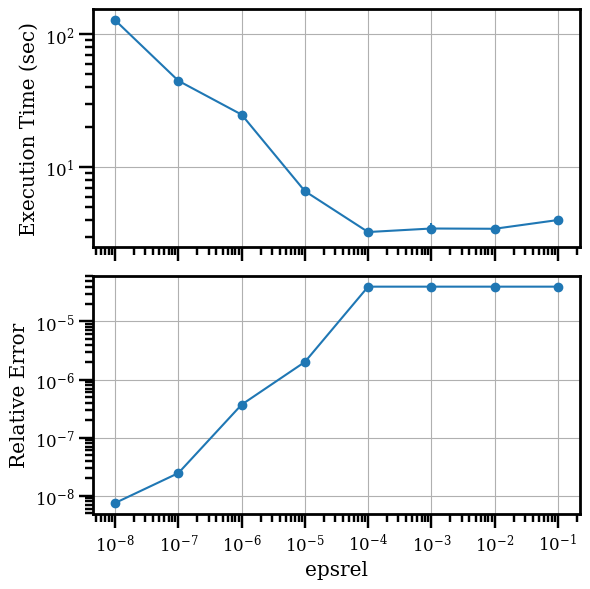

In [6]:
f, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6))

ax[0].errorbar(epsrel, tt, et, fmt='o-')
jp.pplot(ax[0], xscl='log', yscl='log', ylabel='Execution Time (sec)', skipline=True)
ax[0].grid()

ax[1].plot(epsrel, ferr/flxs, '-o')
jp.pplot(ax[1], xscl='log', yscl='log', ylabel='Relative Error', xlabel='epsrel', skipline=True)
ax[1].grid()

Excution time decrease with epsrel approximately following a power law until 1e-4.  THe relative error increases also approximately following a power law until 4e-5 (0.001%).  Can set default epsrel to 1e-3.

## Verify Table II

Check the phase function for NEATM, compare against Table II in Harris (1998).

In [7]:
from jylipy.thermal import STM, NEATM

phase = np.concatenate([np.linspace(0, 120, 13) * u.deg, [180 * u.deg]])
ph_slp = 0.01 * u.mag / u.deg
wv = [4.8, 10, 20] * u.um

stm = STM(1 * u.au, 10 * u.km, albedo=0.07, emissivity=0.9)
ph_corr_stm = stm._phase_corr(phase, ph_slp)

neatm = NEATM(1 * u.au, 10 * u.km, albedo=0.07, emissivity=0.9, beaming=0.756)
flx = u.Quantity([u.Quantity([neatm.fluxd(w, 1 * u.au, p) for p in phase]) for w in wv])
flx0 = (flx.T / flx[:, 0]).T

print('Subsolar temperature STM = {:.2f}'.format(stm.Tss))
print('Subsolar temperature NEATM = {:.2f}'.format(neatm.Tss))

/Users/jyli/.env/work/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Subsolar temperature STM = 425.60 K
Subsolar temperature NEATM = 425.60 K


In [8]:
from astropy.table import Table

out = Table([phase, ph_corr_stm, flx0[0], flx0[1], flx0[2]], names=['phase', 'STM', '4.8', '10', '20'])
out['STM'].format = '.3f'
out['4.8'].format = '.3f'
out['10'].format = '.3f'
out['20'].format = '.3f'
out

phase,STM,4.8,10,20
deg,,,,
float64,float64,float64,float64,float64
0.0,1.000,1.000,1.000,1.000
10.0,0.912,0.985,0.985,0.986
20.0,0.832,0.940,0.943,0.948
30.0,0.759,0.870,0.879,0.890
40.0,0.692,0.779,0.797,0.817
50.0,0.631,0.673,0.705,0.733
60.0,0.575,0.561,0.605,0.642
70.0,0.525,0.449,0.504,0.548


In [9]:
# Table 2 in Harris (1998)

stm_slp = [1, 0.912, 0.832, 0.759, 0.692, 0.631, 0.575, 0.525, 0.479, 0.437, 0.398, 0.363, 0.331, 0.191]
neatm5 = [1., 0.985, 0.940, 0.870, 0.778, 0.673, 0.561, 0.449, 0.344, 0.249, 0.170, 0.107, 0.061, 0]
neatm10 = [1., 0.985, 0.943, 0.879, 0.797, 0.705, 0.605, 0.504, 0.406, 0.314, 0.232, 0.162, 0.105, 0]
neatm20 = [1., 0.986, 0.948, 0.890, 0.817, 0.733, 0.642, 0.548, 0.454, 0.364, 0.281, 0.206, 0.142, 0]

table2 = Table([phase, stm_slp, neatm5, neatm10, neatm20], names=['phase', 'STM', '4.8', '10', '20'])

for k in ['STM', '4.8', '10', '20']:
    assert np.allclose(out[k], table2[k], atol=1e-3)
    
table2

phase,STM,4.8,10,20
deg,,,,
float64,float64,float64,float64,float64
0.0,1.0,1.0,1.0,1.0
10.0,0.912,0.985,0.985,0.986
20.0,0.832,0.94,0.943,0.948
30.0,0.759,0.87,0.879,0.89
40.0,0.692,0.778,0.797,0.817
50.0,0.631,0.673,0.705,0.733
60.0,0.575,0.561,0.605,0.642
70.0,0.525,0.449,0.504,0.548


## Compare with Fig. 1

In [10]:
from time import time
from jylipy.thermal import STM, FRM, NEATM

wv = np.linspace(3, 30, 20) * u.um
flx_unit = 'W m-2 um-1'
q = 0.3 # phase integral

flx = []
for r in data:
    print(r)
    t0 = time()

    stm = STM(r['r'], r['R_stm'], r['alb_stm'] * q, emissivity=1)
    flx_stm = u.Quantity([stm.fluxd(w, r['delta'], r['phase'], unit=flx_unit) for w in wv])
    
    frm = FRM(r['r'], r['R_frm'], r['alb_frm'] * q, emissivity=1)
    flx_frm = u.Quantity([frm.fluxd(w, r['delta'], unit=flx_unit) for w in wv])
    
    neatm = NEATM(r['r'], r['R_neatm'], r['alb_neatm'] * q, emissivity=1, beaming=r['eta'])
    flx_neatm = u.Quantity([neatm.fluxd(w, r['delta'], r['phase'], unit=flx_unit) for w in wv])
    
    flx.append(np.vstack([flx_stm, flx_frm, flx_neatm]))
    
    print('time ellapsed {:.2f} s\n'.format(time() - t0))

flx = u.Quantity(flx)


name   r   delta phase R_stm R_frm R_neatm alb_stm alb_frm alb_neatm eta 
       AU    AU   deg    km    km     km                                 
---- ----- ----- ----- ----- ----- ------- ------- ------- --------- ----
Eros 1.134 0.153   9.9 10.25  18.1    11.8    0.27    0.09       0.2 1.05
time ellapsed 315.17 s

 name    r   delta phase R_stm R_frm R_neatm alb_stm alb_frm alb_neatm eta 
         AU    AU   deg    km    km     km                                 
------ ----- ----- ----- ----- ----- ------- ------- ------- --------- ----
Apollo 1.105 0.148  35.0  0.62  0.94   0.725    0.35    0.15      0.26 1.15
time ellapsed 648.39 s

  name     r   delta phase R_stm R_frm R_neatm alb_stm alb_frm alb_neatm eta
           AU    AU   deg    km    km     km                                
-------- ----- ----- ----- ----- ----- ------- ------- ------- --------- ---
Phaethon 1.131 0.246  48.3 1.785 2.795   2.565    0.22    0.09      0.11 1.6
time ellapsed 534.15 s



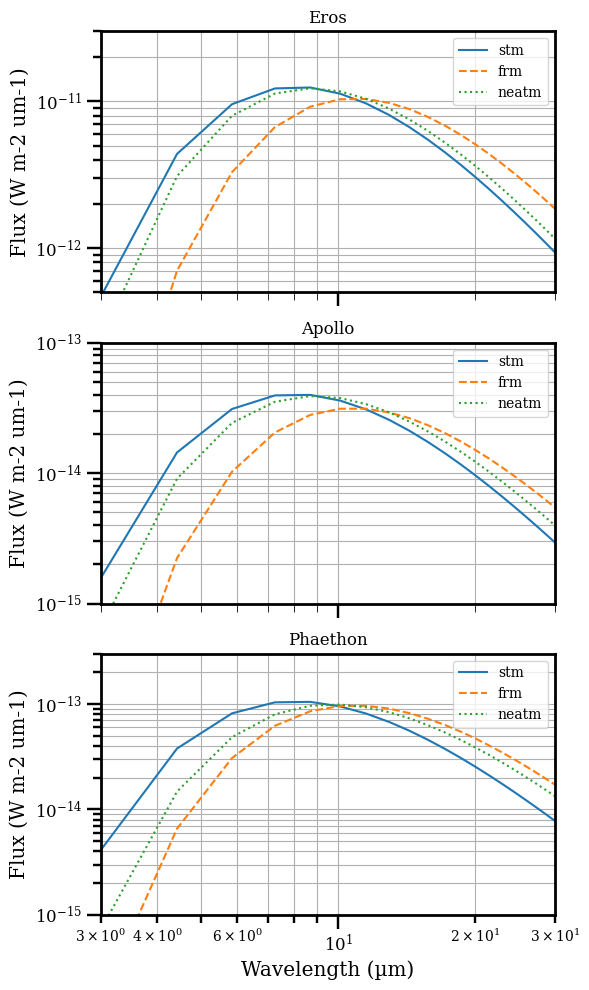

In [11]:
# plot

obj = ['Eros', 'Apollo', 'Phaethon']
ls = ['-', '--', ':']
ylim = [[5e-13, 3e-11], [1e-15, 1e-13], [1e-15, 3e-13]]

f, ax = plt.subplots(3, 1, sharex=True, figsize=[6, 10])

for j in range(3):
    for i in range(3):
        ax[j].plot(wv, flx[j, i], ls=ls[i])
    ax[j].legend(['stm', 'frm', 'neatm'])
    jp.pplot(ax[j], yscl='log', ylim=ylim[j], title=obj[j], ylabel='Flux ({})'.format(flx_unit))
    ax[j].grid(which='both')

jp.pplot(ax[-1], xscl='log', xlim=[3, 30], xticks=[5, 10, 20], xlabel='Wavelength (µm)')